# Polarity Detection using CNN on Movie Review Dataset
Increase the data to get a better result

[Dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/)

## Contents
* Data Cleaning
* Data Understanding
* Data Preprocessing
* Modeling

In [98]:
import os
import numpy as np
from nltk.corpus import stopwords
from nltk import word_tokenize
from string import punctuation
import random
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Conv1D, MaxPool1D, Dropout, BatchNormalization
from tensorflow.keras.layers import concatenate

### Data Cleaning
* Punctuation removal
* Stopwords removal
* Word tokenization
* Train-test split

In [2]:
stop_words = stopwords.words('english')

In [3]:
negative_documents = []
max_len_negative = 0
for file in os.listdir('data/neg'):
    with open('data/neg/' + file) as f:
        text = f.read()
        tokens = word_tokenize(text)
        translator = str.maketrans('', '', punctuation)
        tokens = [w.translate(translator) for w in tokens]
        tokens = [w for w in tokens if not w in stop_words]
        if len(tokens) > max_len_negative:
            max_len_negative = len(tokens)
        negative_documents.append(' '.join(tokens))
len(negative_documents)

1000

In [6]:
positive_documents = []
max_len_positive = 0
for file in os.listdir('data/pos'):
    with open('data/pos/' + file) as f:
        text = f.read()
        tokens = word_tokenize(text)
        translator = str.maketrans('', '', punctuation)
        tokens = [w.translate(translator) for w in tokens]
        tokens = [w for w in tokens if not w in stop_words]
        if len(tokens) > max_len_positive:
            max_len_positive = len(tokens)
        positive_documents.append(' '.join(tokens))
len(positive_documents)

1000

In [7]:
max_len_positive

1693

In [8]:
max_len_negative

1400

We need maximum number of words for text padding

In [9]:
max_len = max(max_len_negative, max_len_positive)

So we have 2000 documents belonging to 2 classes

Each document is a review and it can be negative or positive

Maximum number of words for positive reviews is 1693 and for negative reviews is 1400

In [10]:
random.shuffle(negative_documents)
random.shuffle(positive_documents)

We assign 0 for negative reviews and 1 for positive ones

In [11]:
X_train = negative_documents[:800] + positive_documents[:800]
y_train = [0 for _ in range(800)] + [1 for _ in range(800)]

X_test = negative_documents[800:] + positive_documents[800:]
y_test = [0 for _ in range(200)] + [1 for _ in range(200)]

In [13]:
len(X_train)

1600

In [14]:
len(X_test)

400

In [16]:
X_train[0]

'sad irony screened fright night part 2 day one stars  roddy mcdowall passed away age 70  mcdowall one talented prolific actors hollywood  career spanned 60 years appearing 100 films  fright night part 2 probably counted among memorable roles  really sad considering good first fright night film  william ragsdale roddy mcdowall reprised roles somewhat reluctant vampire killers seem ones realize vampires walk among us   least movies anyway   several years since charlie brewster  ragsdale  bmovie actor turned late night horror film host  peter vincent  mcdowall  came face face real live vampire happened charlie next door neighbor  charlie peter battle  apparently even vampires relatives get pissed kill members family  apparently charlie former bloodsucking next door neighbor sister none pleased find kid aging actor staked sibling  decides exact little bit revenge  ends forcing charlie peter battle forces darkness yet  one things made fright night success chris sarandon played charlie styl

In [17]:
y_train[0]

0

### Data Preprocessing
* Tokenizing
* Encoding
* Text padding

In [18]:
max_len

1693

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
tokenizer

In [25]:
len(tokenizer.word_index)

40705

In [53]:
vocab_len = len(tokenizer.word_index) + 1

40705 unique words

In [45]:
encoded = tokenizer.texts_to_sequences(X_train)

In [47]:
len(encoded)

1600

In [49]:
encoded[0][:10]

[1181, 3792, 6920, 4574, 205, 104, 217, 111, 4, 269]

Now we can apply text padding

In [50]:
padded = pad_sequences(encoded, maxlen=max_len, padding='post')

In [51]:
padded.shape

(1600, 1693)

In [52]:
padded[0]

array([1181, 3792, 6920, ...,    0,    0,    0])

In [59]:
encoded_test = tokenizer.texts_to_sequences(X_test)
padded_test = pad_sequences(encoded_test, maxlen=max_len, padding='post')

### Modeling

In [122]:
input1 = Input(shape=(max_len,))
embedding1 = Embedding(vocab_len, 100)(input1)

conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
drop1 = Dropout(0.4)(conv1)
pool1 = MaxPool1D(pool_size=2)(drop1)

conv2 = Conv1D(filters=64, kernel_size=4, activation='relu')(pool1)
drop2 = Dropout(0.4)(conv2)
pool2 = MaxPool1D(pool_size=2)(drop2)

flat1 = Flatten()(pool2)
dense1 = Dense(10, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(dense1)

In [123]:
model = Model(inputs=[input1], outputs=output)

In [124]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [125]:
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1693)]            0         
                                                                 
 embedding_16 (Embedding)    (None, 1693, 100)         4070600   
                                                                 
 conv1d_30 (Conv1D)          (None, 1690, 32)          12832     
                                                                 
 dropout_31 (Dropout)        (None, 1690, 32)          0         
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 845, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_31 (Conv1D)          (None, 842, 64)           8256      
                                                          

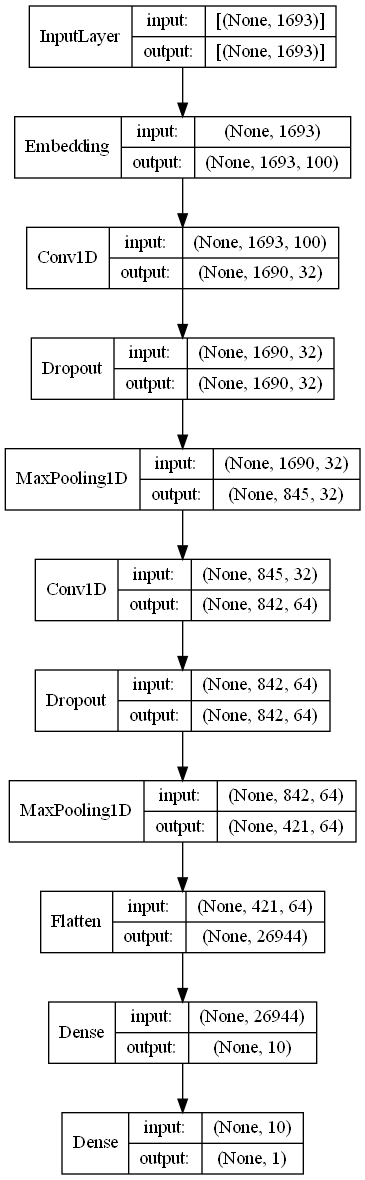

In [126]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [127]:
history = model.fit([padded], np.array(y_train), epochs=7, batch_size=20,
                    validation_data=([padded_test], np.array(y_test)))

Epoch 1/7
80/80 [==============================] - 14s 172ms/step - loss: 0.6915 - accuracy: 0.5188 - val_loss: 0.6863 - val_accuracy: 0.5500
Epoch 2/7
80/80 [==============================] - 14s 171ms/step - loss: 0.6370 - accuracy: 0.6081 - val_loss: 0.6267 - val_accuracy: 0.7025
Epoch 3/7
80/80 [==============================] - 14s 175ms/step - loss: 0.4649 - accuracy: 0.8487 - val_loss: 0.5599 - val_accuracy: 0.7875
Epoch 4/7
80/80 [==============================] - 13s 161ms/step - loss: 0.1972 - accuracy: 0.9344 - val_loss: 0.4315 - val_accuracy: 0.8275
Epoch 5/7
80/80 [==============================] - 13s 163ms/step - loss: 0.0307 - accuracy: 0.9925 - val_loss: 0.4866 - val_accuracy: 0.8325
Epoch 6/7
80/80 [==============================] - 13s 158ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5014 - val_accuracy: 0.8350
Epoch 7/7
80/80 [==============================] - 14s 177ms/step - loss: 6.1912e-04 - accuracy: 1.0000 - val_loss: 0.5130 - val_accuracy: 0.8425
